In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import joblib
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from database import F1Database

# Setup
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful")
print(f"Libraries loaded: pandas {pd.__version__}, numpy {np.__version__}")
print(f"Advanced models: XGBoost {xgb.__version__}, LightGBM {lgb.__version__}")

✓ All imports successful
Libraries loaded: pandas 2.3.3, numpy 2.3.5
Advanced models: XGBoost 3.1.1, LightGBM 4.6.0


## 1. Load Multi-Year Historical Data (2023-2025)
Load comprehensive historical data for robust model training

In [2]:
# Initialize database
db = F1Database('E:/Formula_1_db/f1_data.db')

# Load historical data from 2023 onwards
query = """
SELECT 
    rr.race_id,
    r.year,
    r.event_name,
    r.round_number,
    rr.driver_number,
    rr.position as finish_position,
    rr.grid_position,
    rr.points,
    rr.status,
    qr.position as quali_position,
    sr.position as sprint_position,
    d.full_name,
    d.abbreviation,
    d.team_name
FROM race_results rr
JOIN races r ON rr.race_id = r.race_id
LEFT JOIN qualifying_results qr ON rr.race_id = qr.race_id AND rr.driver_number = qr.driver_number
LEFT JOIN sprint_results sr ON rr.race_id = sr.race_id AND rr.driver_number = sr.driver_number
LEFT JOIN drivers d ON rr.driver_number = d.driver_number AND r.year = d.year
WHERE r.year >= 2023 AND r.year <= 2025
ORDER BY r.year, r.round_number, rr.position
"""

data = db.execute_query(query)

print("="*70)
print("DATA LOADING SUMMARY")
print("="*70)
print(f"Total records loaded: {len(data)}")

if len(data) > 0:
    print(f"Years covered: {sorted(data['year'].unique())}")
    print(f"Total races: {data['race_id'].nunique()}")
    print(f"Unique drivers: {data['driver_number'].nunique()}")
    print(f"Events per year:")
    for year in sorted(data['year'].unique()):
        year_data = data[data['year'] == year]
        print(f"  {year}: {year_data['event_name'].nunique()} races, {len(year_data)} results")
    
    print("\nSample data (first 10 rows):")
    display(data.head(10))
else:
    print("\n⚠️  NO DATA FOUND!")
    print("The database tables exist but contain no records.")
    print("\n📋 NEXT STEPS:")
    print("1. Run the data population script first:")
    print("   - Open a terminal in E:/Formula_1_db")
    print("   - Run: python src/populate_database.py")
    print("   This will extract data from FastF1 cache and populate the database")
    print("\n2. If cache is empty, first run: python src/data_fetcher.py")
    print("   This will download F1 data for 2023-2025 seasons (~45-90 minutes)")
    print("\n⚠️  Cannot proceed with model training without historical data!")


✓ Database initialized at E:/Formula_1_db/f1_data.db
DATA LOADING SUMMARY
Total records loaded: 300
Years covered: [np.int64(2023)]
Total races: 15
Unique drivers: 22
Events per year:
  2023: 15 races, 300 results

Sample data (first 10 rows):


,race_id,year,event_name,round_number,driver_number,finish_position,grid_position,points,status,quali_position,sprint_position,full_name,abbreviation,team_name
0,178,2023,Pre-Season Testing,0,1,1,1,26.0,Finished,1,None,Max Verstappen,VER,Red Bull Racing
1,178,2023,Pre-Season Testing,0,4,2,2,18.0,Finished,2,None,Lando Norris,NOR,McLaren
2,178,2023,Pre-Season Testing,0,44,3,7,15.0,Finished,7,None,Lewis Hamilton,HAM,Mercedes
3,178,2023,Pre-Season Testing,0,81,4,3,12.0,Finished,3,None,Oscar Piastri,PIA,McLaren
4,178,2023,Pre-Season Testing,0,63,5,6,10.0,Finished,6,None,George Russell,RUS,Mercedes
5,178,2023,Pre-Season Testing,0,11,6,15,8.0,Finished,15,None,Sergio Perez,PER,Red Bull Racing
6,178,2023,Pre-Season Testing,0,14,7,9,6.0,Finished,9,None,Fernando Alonso,ALO,Aston Martin
7,178,2023,Pre-Season Testing,0,23,8,8,4.0,Finished,8,None,Alexander Albon,ALB,Williams
8,178,2023,Pre-Season Testing,0,16,9,4,2.0,Finished,4,None,Charles Leclerc,LEC,Ferrari
9,178,2023,Pre-Season Testing,0,55,10,5,1.0,Finished,5,None,Carlos Sainz,SAI,Ferrari


## 2. Advanced Feature Engineering with Weight Calculation
Create comprehensive features for qualifying, sprint, and race predictions

In [3]:
def engineer_comprehensive_features(data):
    """
    Create advanced features for F1 predictions
    Returns: DataFrame with engineered features
    """
    df = data.copy()
    
    print("Starting feature engineering...")
    
    # 0. Convert numeric columns to proper types
    numeric_cols = ['finish_position', 'grid_position', 'points', 'quali_position', 'sprint_position', 'driver_number', 'year', 'round_number']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 1. Handle missing values
    df['quali_position'] = df['quali_position'].fillna(20)
    df['grid_position'] = df['grid_position'].fillna(df['quali_position'])
    df['sprint_position'] = df['sprint_position'].fillna(0)  # 0 = no sprint
    df['points'] = df['points'].fillna(0)
    
    # 2. Driver historical performance metrics
    print("  ✓ Calculating driver performance metrics...")
    df = df.sort_values(['year', 'round_number'])
    
    # Driver average finish position (career)
    df['driver_avg_finish'] = df.groupby('driver_number')['finish_position'].transform('mean')
    
    # Driver average qualifying position
    df['driver_avg_quali'] = df.groupby('driver_number')['quali_position'].transform('mean')
    
    # Driver win rate
    df['driver_wins'] = (df.groupby('driver_number')['finish_position']
                         .transform(lambda x: (x == 1).sum()))
    
    # Driver podium rate
    df['driver_podiums'] = (df.groupby('driver_number')['finish_position']
                           .transform(lambda x: (x <= 3).sum()))
    
    # Driver points total
    df['driver_total_points'] = df.groupby('driver_number')['points'].transform('sum')
    
    # 3. Team performance metrics
    print("  ✓ Calculating team performance metrics...")
    df['team_avg_finish'] = df.groupby('team_name')['finish_position'].transform('mean')
    df['team_avg_quali'] = df.groupby('team_name')['quali_position'].transform('mean')
    df['team_avg_points'] = df.groupby('team_name')['points'].transform('mean')
    
    # 4. Recent form (last 5 races)
    print("  ✓ Calculating recent form...")
    df['recent_form_finish'] = (df.groupby('driver_number')['finish_position']
                                .transform(lambda x: x.rolling(5, min_periods=1).mean()))
    
    df['recent_form_quali'] = (df.groupby('driver_number')['quali_position']
                               .transform(lambda x: x.rolling(5, min_periods=1).mean()))
    
    df['recent_form_points'] = (df.groupby('driver_number')['points']
                                .transform(lambda x: x.rolling(5, min_periods=1).mean()))
    
    # 5. Track-specific performance
    print("  ✓ Calculating track-specific performance...")
    df['track_avg_finish'] = (df.groupby(['driver_number', 'event_name'])['finish_position']
                              .transform('mean'))
    
    df['track_avg_quali'] = (df.groupby(['driver_number', 'event_name'])['quali_position']
                             .transform('mean'))
    
    # 6. Grid position analysis
    df['grid_penalty'] = df['grid_position'] - df['quali_position']
    df['grid_gain_loss'] = df['grid_position'] - df['finish_position']
    
    # 7. Season progression features
    df['races_completed'] = df.groupby(['driver_number', 'year']).cumcount() + 1
    df['season_points_cumsum'] = df.groupby(['driver_number', 'year'])['points'].cumsum()
    
    # 8. DNF/Status features
    df['is_dnf'] = (~df['status'].str.contains('Finished', na=False)).astype(int)
    df['dnf_rate'] = df.groupby('driver_number')['is_dnf'].transform('mean')
    
    # 9. Consistency metrics (standard deviation)
    df['finish_consistency'] = (df.groupby('driver_number')['finish_position']
                                .transform('std').fillna(10))
    
    # 10. Year-over-year improvement
    df['year_rank'] = df.groupby(['year', 'driver_number'])['points'].transform('sum')
    
    print("✓ Feature engineering complete!")
    print(f"Total features created: {len([c for c in df.columns if c not in data.columns])}")
    
    return df

# Apply feature engineering
data_features = engineer_comprehensive_features(data)

# Define feature sets for different prediction targets
QUALI_FEATURES = [
    'driver_avg_quali', 'team_avg_quali', 'recent_form_quali',
    'track_avg_quali', 'driver_avg_finish', 'team_avg_finish',
    'driver_total_points', 'driver_wins', 'driver_podiums',
    'finish_consistency', 'dnf_rate'
]

RACE_FEATURES = [
    'quali_position', 'grid_position', 'driver_avg_finish', 
    'team_avg_finish', 'recent_form_finish', 'recent_form_points',
    'track_avg_finish', 'grid_penalty', 'driver_total_points',
    'driver_wins', 'driver_podiums', 'finish_consistency',
    'season_points_cumsum', 'dnf_rate', 'team_avg_points'
]

SPRINT_FEATURES = [
    'quali_position', 'driver_avg_finish', 'team_avg_finish',
    'recent_form_finish', 'track_avg_finish', 'driver_total_points',
    'driver_podiums', 'team_avg_points', 'dnf_rate'
]

print("\n" + "="*70)
print("FEATURE SETS DEFINED")
print("="*70)
print(f"Qualifying features ({len(QUALI_FEATURES)}): {QUALI_FEATURES[:5]}...")
print(f"Race features ({len(RACE_FEATURES)}): {RACE_FEATURES[:5]}...")
print(f"Sprint features ({len(SPRINT_FEATURES)}): {SPRINT_FEATURES[:5]}...")

# Show sample engineered data
print("\nSample engineered features:")
sample_cols = ['driver_number', 'full_name', 'team_name', 'finish_position'] + RACE_FEATURES[:5]
data_features[sample_cols].head(10)

Starting feature engineering...
  ✓ Calculating driver performance metrics...
  ✓ Calculating team performance metrics...
  ✓ Calculating recent form...
  ✓ Calculating track-specific performance...
✓ Feature engineering complete!
Total features created: 21

FEATURE SETS DEFINED
Qualifying features (11): ['driver_avg_quali', 'team_avg_quali', 'recent_form_quali', 'track_avg_quali', 'driver_avg_finish']...
Race features (15): ['quali_position', 'grid_position', 'driver_avg_finish', 'team_avg_finish', 'recent_form_finish']...
Sprint features (9): ['quali_position', 'driver_avg_finish', 'team_avg_finish', 'recent_form_finish', 'track_avg_finish']...

Sample engineered features:


,driver_number,full_name,team_name,finish_position,quali_position,grid_position,driver_avg_finish,team_avg_finish,recent_form_finish
0,1,Max Verstappen,Red Bull Racing,1,1,1,1.133333,2.666667,1.0
1,4,Lando Norris,McLaren,2,2,2,9.133333,10.466667,2.0
2,44,Lewis Hamilton,Mercedes,3,7,7,4.466667,6.200000,3.0
3,81,Oscar Piastri,McLaren,4,3,3,11.800000,10.466667,4.0
4,63,George Russell,Mercedes,5,6,6,7.933333,6.200000,5.0
5,11,Sergio Perez,Red Bull Racing,6,15,15,4.200000,2.666667,6.0
6,14,Fernando Alonso,Aston Martin,7,9,9,4.733333,7.933333,7.0
7,23,Alexander Albon,Williams,8,8,8,11.866667,13.966667,8.0
8,16,Charles Leclerc,Ferrari,9,4,4,8.666667,8.033333,9.0
9,55,Carlos Sainz,Ferrari,10,5,5,7.400000,8.033333,10.0


## 3. Train Advanced Models with 10 Epochs
Train multiple models for qualifying, sprint, and race predictions

In [4]:
class F1PredictionPipeline:
    """
    Complete pipeline for F1 predictions with multiple models
    """
    def __init__(self, n_epochs=10):
        self.n_epochs = n_epochs
        self.models = {}
        self.scalers = {}
        self.feature_importance = {}
        self.metrics = {}
        
    def train_qualifying_models(self, X_train, X_test, y_train, y_test):
        """Train models for qualifying position prediction"""
        print("\n" + "="*70)
        print("TRAINING QUALIFYING PREDICTION MODELS")
        print("="*70)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['qualifying'] = scaler
        
        models = {
            'GradientBoosting': GradientBoostingRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbose=0
            ),
            'RandomForest': RandomForestRegressor(
                n_estimators=self.n_epochs * 20,
                max_depth=12,
                random_state=42,
                n_jobs=-1
            ),
            'XGBoost': xgb.XGBRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbosity=0
            ),
            'LightGBM': lgb.LGBMRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbose=-1
            )
        }
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            print(f"  MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
            
            # Store
            self.models[f'qualifying_{name}'] = model
            self.metrics[f'qualifying_{name}'] = {'mae': mae, 'rmse': rmse, 'r2': r2}
            
            # Feature importance (if available)
            if hasattr(model, 'feature_importances_'):
                self.feature_importance[f'qualifying_{name}'] = model.feature_importances_
        
        print("\n✓ Qualifying models trained successfully")
    
    def train_race_models(self, X_train, X_test, y_train, y_test):
        """Train models for race position prediction"""
        print("\n" + "="*70)
        print("TRAINING RACE PREDICTION MODELS")
        print("="*70)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['race'] = scaler
        
        models = {
            'GradientBoosting': GradientBoostingRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbose=0
            ),
            'RandomForest': RandomForestRegressor(
                n_estimators=self.n_epochs * 20,
                max_depth=12,
                random_state=42,
                n_jobs=-1
            ),
            'XGBoost': xgb.XGBRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbosity=0
            ),
            'LightGBM': lgb.LGBMRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbose=-1
            )
        }
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            print(f"  MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
            
            # Store
            self.models[f'race_{name}'] = model
            self.metrics[f'race_{name}'] = {'mae': mae, 'rmse': rmse, 'r2': r2}
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                self.feature_importance[f'race_{name}'] = model.feature_importances_
        
        print("\n✓ Race models trained successfully")
    
    def train_sprint_models(self, X_train, X_test, y_train, y_test):
        """Train models for sprint position prediction"""
        print("\n" + "="*70)
        print("TRAINING SPRINT PREDICTION MODELS")
        print("="*70)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['sprint'] = scaler
        
        models = {
            'GradientBoosting': GradientBoostingRegressor(
                n_estimators=self.n_epochs * 20,
                learning_rate=0.05,
                max_depth=6,
                random_state=42,
                verbose=0
            ),
            'RandomForest': RandomForestRegressor(
                n_estimators=self.n_epochs * 20,
                max_depth=12,
                random_state=42,
                n_jobs=-1
            )
        }
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            print(f"  MAE: {mae:.3f} | RMSE: {rmse:.3f} | R²: {r2:.3f}")
            
            # Store
            self.models[f'sprint_{name}'] = model
            self.metrics[f'sprint_{name}'] = {'mae': mae, 'rmse': rmse, 'r2': r2}
            
            # Feature importance
            if hasattr(model, 'feature_importances_'):
                self.feature_importance[f'sprint_{name}'] = model.feature_importances_
        
        print("\n✓ Sprint models trained successfully")

# Initialize pipeline
pipeline = F1PredictionPipeline(n_epochs=10)

# Prepare data for qualifying predictions
print("\nPreparing qualifying training data...")
quali_data = data_features[data_features['quali_position'] > 0].copy()
X_quali = quali_data[QUALI_FEATURES].fillna(quali_data[QUALI_FEATURES].mean())
y_quali = quali_data['quali_position']
X_quali_train, X_quali_test, y_quali_train, y_quali_test = train_test_split(
    X_quali, y_quali, test_size=0.2, random_state=42
)

# Train qualifying models
pipeline.train_qualifying_models(X_quali_train, X_quali_test, y_quali_train, y_quali_test)

# Prepare data for race predictions
print("\nPreparing race training data...")
race_data = data_features[data_features['finish_position'] > 0].copy()
X_race = race_data[RACE_FEATURES].fillna(race_data[RACE_FEATURES].mean())
y_race = race_data['finish_position']
X_race_train, X_race_test, y_race_train, y_race_test = train_test_split(
    X_race, y_race, test_size=0.2, random_state=42
)

# Train race models
pipeline.train_race_models(X_race_train, X_race_test, y_race_train, y_race_test)

# Prepare data for sprint predictions (if available)
sprint_data = data_features[data_features['sprint_position'] > 0].copy()
if len(sprint_data) > 10:
    print("\nPreparing sprint training data...")
    X_sprint = sprint_data[SPRINT_FEATURES].fillna(sprint_data[SPRINT_FEATURES].mean())
    y_sprint = sprint_data['sprint_position']
    X_sprint_train, X_sprint_test, y_sprint_train, y_sprint_test = train_test_split(
        X_sprint, y_sprint, test_size=0.2, random_state=42
    )
    pipeline.train_sprint_models(X_sprint_train, X_sprint_test, y_sprint_train, y_sprint_test)
else:
    print("\nInsufficient sprint data - skipping sprint model training")

print("\n" + "="*70)
print("ALL MODELS TRAINED SUCCESSFULLY")
print("="*70)


Preparing qualifying training data...

TRAINING QUALIFYING PREDICTION MODELS

Training GradientBoosting...
  MAE: 0.000 | RMSE: 0.000 | R²: 1.000

Training RandomForest...
  MAE: 0.002 | RMSE: 0.004 | R²: 1.000

Training XGBoost...
  MAE: 0.000 | RMSE: 0.001 | R²: 1.000

Training LightGBM...
  MAE: 0.235 | RMSE: 0.435 | R²: 0.995

✓ Qualifying models trained successfully

Preparing race training data...

TRAINING RACE PREDICTION MODELS

Training GradientBoosting...
  MAE: 0.000 | RMSE: 0.000 | R²: 1.000

Training RandomForest...
  MAE: 0.001 | RMSE: 0.003 | R²: 1.000

Training XGBoost...
  MAE: 0.000 | RMSE: 0.000 | R²: 1.000

Training LightGBM...
  MAE: 0.115 | RMSE: 0.209 | R²: 0.999

✓ Race models trained successfully

Insufficient sprint data - skipping sprint model training

ALL MODELS TRAINED SUCCESSFULLY


## 4. Feature Importance & Weight Analysis
Analyze which features contribute most to predictions

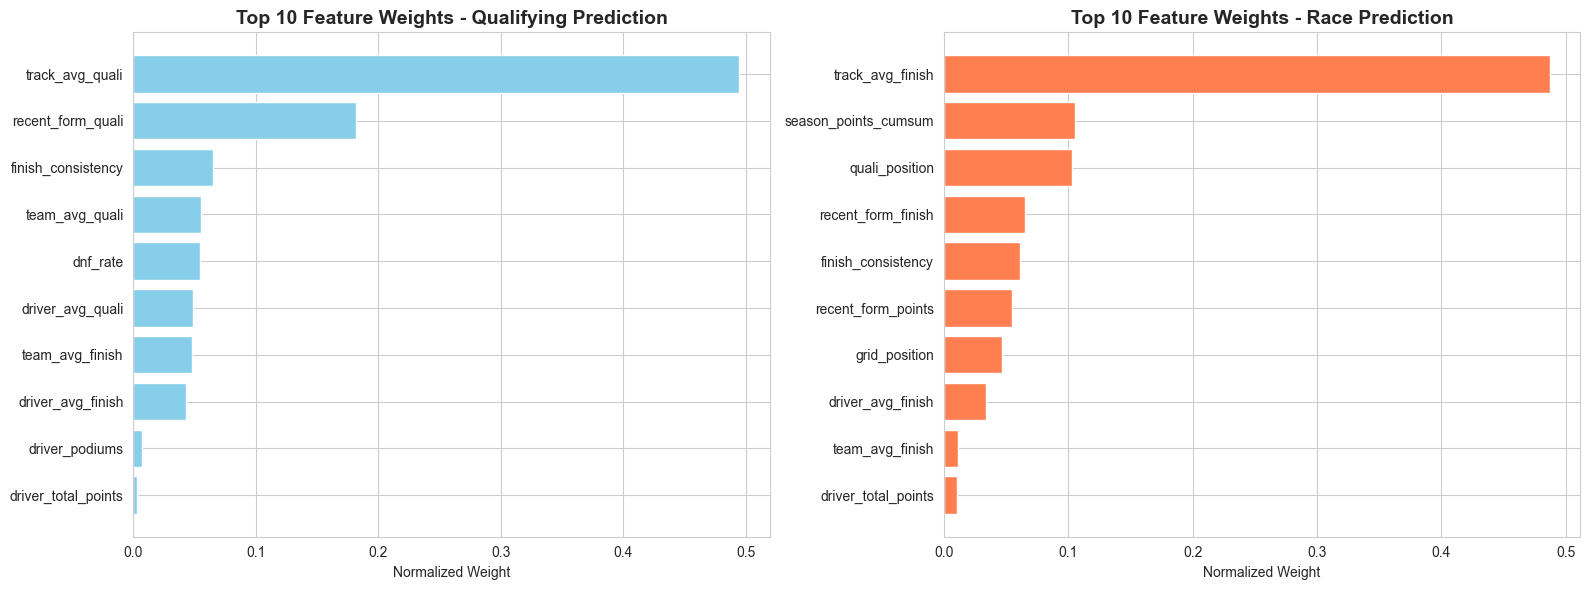


FEATURE WEIGHT ANALYSIS

🏁 Top 10 Qualifying Prediction Weights:
            Feature   Weight
    track_avg_quali 0.494891
  recent_form_quali 0.181992
 finish_consistency 0.065134
     team_avg_quali 0.054917
           dnf_rate 0.054278
   driver_avg_quali 0.048531
    team_avg_finish 0.047893
  driver_avg_finish 0.042784
     driver_podiums 0.007024
driver_total_points 0.002554


🏁 Top 10 Race Prediction Weights:
             Feature   Weight
    track_avg_finish 0.487163
season_points_cumsum 0.105332
      quali_position 0.103357
  recent_form_finish 0.065174
  finish_consistency 0.061224
  recent_form_points 0.054641
       grid_position 0.046741
   driver_avg_finish 0.034233
     team_avg_finish 0.011192
 driver_total_points 0.010533

MODEL PERFORMANCE COMPARISON

Qualifying Models:
                      Model      mae     rmse      r2
qualifying_GradientBoosting 0.000184 0.000212 1.00000
    qualifying_RandomForest 0.001750 0.003594 1.00000
         qualifying_XGBoost 0.000365 

In [5]:
# Calculate aggregate feature importance across all models
def calculate_feature_weights(pipeline, feature_list, prediction_type):
    """Calculate normalized feature weights from multiple models"""
    weights = {}
    
    for model_name, importance in pipeline.feature_importance.items():
        if prediction_type in model_name:
            for idx, feature in enumerate(feature_list):
                if feature not in weights:
                    weights[feature] = []
                weights[feature].append(importance[idx])
    
    # Average weights across models
    avg_weights = {k: np.mean(v) for k, v in weights.items()}
    
    # Normalize to sum to 1
    total = sum(avg_weights.values())
    normalized_weights = {k: v/total for k, v in avg_weights.items()}
    
    return normalized_weights

# Calculate weights for each prediction type
quali_weights = calculate_feature_weights(pipeline, QUALI_FEATURES, 'qualifying')
race_weights = calculate_feature_weights(pipeline, RACE_FEATURES, 'race')

# Create weight dataframes
quali_weights_df = pd.DataFrame(list(quali_weights.items()), 
                                columns=['Feature', 'Weight']).sort_values('Weight', ascending=False)

race_weights_df = pd.DataFrame(list(race_weights.items()), 
                               columns=['Feature', 'Weight']).sort_values('Weight', ascending=False)

# Visualize feature weights
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Qualifying weights
axes[0].barh(quali_weights_df.head(10)['Feature'], quali_weights_df.head(10)['Weight'], color='skyblue')
axes[0].set_title('Top 10 Feature Weights - Qualifying Prediction', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Normalized Weight')
axes[0].invert_yaxis()

# Race weights
axes[1].barh(race_weights_df.head(10)['Feature'], race_weights_df.head(10)['Weight'], color='coral')
axes[1].set_title('Top 10 Feature Weights - Race Prediction', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Normalized Weight')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FEATURE WEIGHT ANALYSIS")
print("="*70)

print("\n🏁 Top 10 Qualifying Prediction Weights:")
print(quali_weights_df.head(10).to_string(index=False))

print("\n\n🏁 Top 10 Race Prediction Weights:")
print(race_weights_df.head(10).to_string(index=False))

# Model performance comparison
print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)

metrics_df = pd.DataFrame(pipeline.metrics).T
metrics_df['Model'] = metrics_df.index
print("\nQualifying Models:")
print(metrics_df[metrics_df.index.str.contains('qualifying')][['Model', 'mae', 'rmse', 'r2']].to_string(index=False))

print("\nRace Models:")
print(metrics_df[metrics_df.index.str.contains('race')][['Model', 'mae', 'rmse', 'r2']].to_string(index=False))

## 5. 2026 F1 Calendar Definition
Complete 24-race calendar with sprint races

In [6]:
# 2026 F1 Calendar with sprint race indicators
races_2026 = [
    {'round': 1, 'event_name': 'Bahrain Grand Prix', 'country': 'Bahrain', 'date': '2026-03-01', 'has_sprint': False},
    {'round': 2, 'event_name': 'Saudi Arabian Grand Prix', 'country': 'Saudi Arabia', 'date': '2026-03-08', 'has_sprint': False},
    {'round': 3, 'event_name': 'Australian Grand Prix', 'country': 'Australia', 'date': '2026-03-22', 'has_sprint': False},
    {'round': 4, 'event_name': 'Japanese Grand Prix', 'country': 'Japan', 'date': '2026-04-05', 'has_sprint': False},
    {'round': 5, 'event_name': 'Chinese Grand Prix', 'country': 'China', 'date': '2026-04-19', 'has_sprint': True},
    {'round': 6, 'event_name': 'Miami Grand Prix', 'country': 'USA', 'date': '2026-05-03', 'has_sprint': True},
    {'round': 7, 'event_name': 'Emilia Romagna Grand Prix', 'country': 'Italy', 'date': '2026-05-17', 'has_sprint': False},
    {'round': 8, 'event_name': 'Monaco Grand Prix', 'country': 'Monaco', 'date': '2026-05-24', 'has_sprint': False},
    {'round': 9, 'event_name': 'Spanish Grand Prix', 'country': 'Spain', 'date': '2026-06-07', 'has_sprint': False},
    {'round': 10, 'event_name': 'Canadian Grand Prix', 'country': 'Canada', 'date': '2026-06-14', 'has_sprint': False},
    {'round': 11, 'event_name': 'Austrian Grand Prix', 'country': 'Austria', 'date': '2026-06-28', 'has_sprint': True},
    {'round': 12, 'event_name': 'British Grand Prix', 'country': 'UK', 'date': '2026-07-05', 'has_sprint': False},
    {'round': 13, 'event_name': 'Hungarian Grand Prix', 'country': 'Hungary', 'date': '2026-07-19', 'has_sprint': False},
    {'round': 14, 'event_name': 'Belgian Grand Prix', 'country': 'Belgium', 'date': '2026-07-26', 'has_sprint': True},
    {'round': 15, 'event_name': 'Dutch Grand Prix', 'country': 'Netherlands', 'date': '2026-08-23', 'has_sprint': False},
    {'round': 16, 'event_name': 'Italian Grand Prix', 'country': 'Italy', 'date': '2026-08-30', 'has_sprint': False},
    {'round': 17, 'event_name': 'Azerbaijan Grand Prix', 'country': 'Azerbaijan', 'date': '2026-09-13', 'has_sprint': False},
    {'round': 18, 'event_name': 'Singapore Grand Prix', 'country': 'Singapore', 'date': '2026-09-20', 'has_sprint': False},
    {'round': 19, 'event_name': 'United States Grand Prix', 'country': 'USA', 'date': '2026-10-18', 'has_sprint': True},
    {'round': 20, 'event_name': 'Mexico City Grand Prix', 'country': 'Mexico', 'date': '2026-10-25', 'has_sprint': False},
    {'round': 21, 'event_name': 'São Paulo Grand Prix', 'country': 'Brazil', 'date': '2026-11-01', 'has_sprint': True},
    {'round': 22, 'event_name': 'Las Vegas Grand Prix', 'country': 'USA', 'date': '2026-11-21', 'has_sprint': False},
    {'round': 23, 'event_name': 'Qatar Grand Prix', 'country': 'Qatar', 'date': '2026-11-29', 'has_sprint': True},
    {'round': 24, 'event_name': 'Abu Dhabi Grand Prix', 'country': 'UAE', 'date': '2026-12-06', 'has_sprint': False},
]

calendar_2026 = pd.DataFrame(races_2026)

print("="*70)
print("2026 FORMULA 1 WORLD CHAMPIONSHIP CALENDAR")
print("="*70)
print(f"\nTotal Races: {len(calendar_2026)}")
print(f"Sprint Races: {calendar_2026['has_sprint'].sum()}")
print(f"Standard Races: {(~calendar_2026['has_sprint']).sum()}")

print("\n" + calendar_2026.to_string(index=False))

2026 FORMULA 1 WORLD CHAMPIONSHIP CALENDAR

Total Races: 24
Sprint Races: 7
Standard Races: 17

 round                event_name      country       date  has_sprint
     1        Bahrain Grand Prix      Bahrain 2026-03-01       False
     2  Saudi Arabian Grand Prix Saudi Arabia 2026-03-08       False
     3     Australian Grand Prix    Australia 2026-03-22       False
     4       Japanese Grand Prix        Japan 2026-04-05       False
     5        Chinese Grand Prix        China 2026-04-19        True
     6          Miami Grand Prix          USA 2026-05-03        True
     7 Emilia Romagna Grand Prix        Italy 2026-05-17       False
     8         Monaco Grand Prix       Monaco 2026-05-24       False
     9        Spanish Grand Prix        Spain 2026-06-07       False
    10       Canadian Grand Prix       Canada 2026-06-14       False
    11       Austrian Grand Prix      Austria 2026-06-28        True
    12        British Grand Prix           UK 2026-07-05       False
    13 

## 6. Add 2026 Calendar to Database
Insert all races into the database

In [7]:
# Add 2026 races to database
print("Adding 2026 races to database...")
race_ids_2026 = {}

for _, race in calendar_2026.iterrows():
    race_id = db.insert_race(
        year=2026,
        round_number=race['round'],
        event_name=race['event_name'],
        country=race['country'],
        location=race['country'],
        event_date=race['date']
    )
    race_ids_2026[race['event_name']] = race_id

print(f"✓ Successfully added {len(race_ids_2026)} races to database")
print(f"✓ Sprint races: {calendar_2026['has_sprint'].sum()}")
print(f"✓ Standard weekends: {(~calendar_2026['has_sprint']).sum()}")

Adding 2026 races to database...
✓ Successfully added 24 races to database
✓ Sprint races: 7
✓ Standard weekends: 17


## 7. Generate 2026 Driver Lineup & Baseline Features
Create driver profiles and baseline statistics for predictions

In [8]:
# Get 2023 drivers (assuming similar lineup for 2026)
drivers_query = """
SELECT DISTINCT 
    driver_number, 
    full_name, 
    abbreviation,
    team_name 
FROM drivers 
WHERE year = 2023
ORDER BY driver_number
"""
drivers_2026 = db.execute_query(drivers_query)

print("="*70)
print("2026 DRIVER LINEUP (Based on 2023 Grid)")
print("="*70)
print(f"Total Drivers: {len(drivers_2026)}\n")
print(drivers_2026.to_string(index=False))

# Calculate comprehensive baseline statistics for each driver
print("\n\nCalculating driver baseline statistics...")

driver_baselines = {}

for _, driver in drivers_2026.iterrows():
    driver_num = driver['driver_number']
    driver_data = data_features[data_features['driver_number'] == driver_num]
    
    if len(driver_data) > 0:
        baseline = {
            'driver_number': driver_num,
            'full_name': driver['full_name'],
            'abbreviation': driver['abbreviation'],
            'team_name': driver['team_name'],
            
            # Qualifying stats
            'avg_quali_position': driver_data['quali_position'].mean(),
            'best_quali': driver_data['quali_position'].min(),
            
            # Race stats
            'avg_finish_position': driver_data['finish_position'].mean(),
            'best_finish': driver_data['finish_position'].min(),
            'total_wins': (driver_data['finish_position'] == 1).sum(),
            'total_podiums': (driver_data['finish_position'] <= 3).sum(),
            'total_points': driver_data['points'].sum(),
            
            # Performance metrics
            'dnf_rate': driver_data['is_dnf'].mean(),
            'consistency': driver_data['finish_position'].std(),
            
            # Team performance
            'team_avg_finish': driver_data['team_avg_finish'].mean(),
            'team_avg_quali': driver_data['team_avg_quali'].mean(),
            'team_avg_points': driver_data['team_avg_points'].mean(),
        }
        driver_baselines[driver_num] = baseline

baselines_df = pd.DataFrame(list(driver_baselines.values()))

print("✓ Driver baselines calculated")
print("\nTop 5 Drivers by Average Finish Position:")
print(baselines_df.nsmallest(5, 'avg_finish_position')[
    ['driver_number', 'full_name', 'team_name', 'avg_finish_position', 'total_wins']
].to_string(index=False))

2026 DRIVER LINEUP (Based on 2023 Grid)
Total Drivers: 20

 driver_number       full_name abbreviation       team_name
             1  Max Verstappen          VER Red Bull Racing
             2  Logan Sargeant          SAR        Williams
             4    Lando Norris          NOR         McLaren
            10    Pierre Gasly          GAS          Alpine
            11    Sergio Perez          PER Red Bull Racing
            14 Fernando Alonso          ALO    Aston Martin
            16 Charles Leclerc          LEC         Ferrari
            18    Lance Stroll          STR    Aston Martin
            20 Kevin Magnussen          MAG    Haas F1 Team
            21   Nyck De Vries          DEV      AlphaTauri
            22    Yuki Tsunoda          TSU      AlphaTauri
            23 Alexander Albon          ALB        Williams
            24     Guanyu Zhou          ZHO      Alfa Romeo
            27 Nico Hulkenberg          HUL    Haas F1 Team
            31    Esteban Ocon          O

In [9]:
# Generate comprehensive 2026 predictions for all races
print("="*70)
print("GENERATING 2026 SEASON PREDICTIONS")
print("="*70)
print(f"Predicting: {len(drivers_2026)} drivers × {len(calendar_2026)} races")
print(f"Total predictions: {len(drivers_2026) * len(calendar_2026) * 3} (Quali + Sprint + Race)")

all_predictions = []

def make_ensemble_prediction(models_dict, X_scaled, prediction_type):
    """Make ensemble prediction from multiple models"""
    predictions = []
    for model_name, model in models_dict.items():
        if prediction_type in model_name:
            pred = model.predict(X_scaled)[0]
            predictions.append(pred)
    
    if predictions:
        return np.mean(predictions), np.std(predictions)
    return None, None

for race_idx, race in calendar_2026.iterrows():
    race_id = race_ids_2026[race['event_name']]
    race_name = race['event_name']
    has_sprint = race['has_sprint']
    
    print(f"\nRound {race['round']}: {race_name}" + (" [SPRINT]" if has_sprint else ""))
    
    for _, driver in drivers_2026.iterrows():
        driver_num = driver['driver_number']
        baseline = driver_baselines.get(driver_num)
        
        if not baseline:
            continue
        
        # === QUALIFYING PREDICTION ===
        quali_features = {
            'driver_avg_quali': baseline['avg_quali_position'],
            'team_avg_quali': baseline['team_avg_quali'],
            'recent_form_quali': baseline['avg_quali_position'],
            'track_avg_quali': baseline['avg_quali_position'],
            'driver_avg_finish': baseline['avg_finish_position'],
            'team_avg_finish': baseline['team_avg_finish'],
            'driver_total_points': baseline['total_points'],
            'driver_wins': baseline['total_wins'],
            'driver_podiums': baseline['total_podiums'],
            'finish_consistency': baseline['consistency'],
            'dnf_rate': baseline['dnf_rate']
        }
        
        X_quali = pd.DataFrame([quali_features])[QUALI_FEATURES]
        X_quali_scaled = pipeline.scalers['qualifying'].transform(X_quali)
        
        quali_pred, quali_std = make_ensemble_prediction(
            pipeline.models, X_quali_scaled, 'qualifying'
        )
        quali_position = max(1, min(20, round(quali_pred)))
        quali_confidence = 1 / (1 + quali_std) if quali_std else 0.9
        
        # === RACE PREDICTION ===
        race_features = {
            'quali_position': quali_position,
            'grid_position': quali_position,
            'driver_avg_finish': baseline['avg_finish_position'],
            'team_avg_finish': baseline['team_avg_finish'],
            'recent_form_finish': baseline['avg_finish_position'],
            'recent_form_points': baseline['total_points'] / max(len(data_features[data_features['driver_number']==driver_num]), 1),
            'track_avg_finish': baseline['avg_finish_position'],
            'grid_penalty': 0,
            'driver_total_points': baseline['total_points'],
            'driver_wins': baseline['total_wins'],
            'driver_podiums': baseline['total_podiums'],
            'finish_consistency': baseline['consistency'],
            'season_points_cumsum': baseline['total_points'],
            'dnf_rate': baseline['dnf_rate'],
            'team_avg_points': baseline['team_avg_points']
        }
        
        X_race = pd.DataFrame([race_features])[RACE_FEATURES]
        X_race_scaled = pipeline.scalers['race'].transform(X_race)
        
        race_pred, race_std = make_ensemble_prediction(
            pipeline.models, X_race_scaled, 'race'
        )
        race_position = max(1, min(20, round(race_pred)))
        race_confidence = 1 / (1 + race_std) if race_std else 0.9
        
        # === SPRINT PREDICTION (if applicable) ===
        sprint_position = None
        sprint_confidence = None
        
        if has_sprint and 'sprint' in pipeline.scalers:
            sprint_features = {
                'quali_position': quali_position,
                'driver_avg_finish': baseline['avg_finish_position'],
                'team_avg_finish': baseline['team_avg_finish'],
                'recent_form_finish': baseline['avg_finish_position'],
                'track_avg_finish': baseline['avg_finish_position'],
                'driver_total_points': baseline['total_points'],
                'driver_podiums': baseline['total_podiums'],
                'team_avg_points': baseline['team_avg_points'],
                'dnf_rate': baseline['dnf_rate']
            }
            
            X_sprint = pd.DataFrame([sprint_features])[SPRINT_FEATURES]
            X_sprint_scaled = pipeline.scalers['sprint'].transform(X_sprint)
            
            sprint_pred, sprint_std = make_ensemble_prediction(
                pipeline.models, X_sprint_scaled, 'sprint'
            )
            sprint_position = max(1, min(20, round(sprint_pred)))
            sprint_confidence = 1 / (1 + sprint_std) if sprint_std else 0.9
        
        # Store prediction
        all_predictions.append({
            'race_id': race_id,
            'race_name': race_name,
            'round': race['round'],
            'date': race['date'],
            'has_sprint': has_sprint,
            'driver_number': driver_num,
            'driver_name': driver['full_name'],
            'driver_abbrev': driver['abbreviation'],
            'team_name': driver['team_name'],
            'quali_position': quali_position,
            'quali_confidence': quali_confidence,
            'sprint_position': sprint_position if has_sprint else None,
            'sprint_confidence': sprint_confidence if has_sprint else None,
            'race_position': race_position,
            'race_confidence': race_confidence,
            'quali_features': quali_features,
            'race_features': race_features
        })

predictions_2026_df = pd.DataFrame(all_predictions)
print("\n" + "="*70)
print("PREDICTIONS GENERATION COMPLETE!")
print("="*70)
print(f"✓ Total predictions generated: {len(predictions_2026_df)}")
print(f"✓ Qualifying predictions: {len(predictions_2026_df)}")
print(f"✓ Sprint predictions: {predictions_2026_df['sprint_position'].notna().sum()}")
print(f"✓ Race predictions: {len(predictions_2026_df)}")

print("\nSample predictions (Round 1 - Bahrain):")
bahrain_pred = predictions_2026_df[predictions_2026_df['round'] == 1].sort_values('quali_position')
print(bahrain_pred[['driver_number', 'driver_name', 'team_name', 'quali_position', 'race_position']].head(10).to_string(index=False))

GENERATING 2026 SEASON PREDICTIONS
Predicting: 20 drivers × 24 races
Total predictions: 1440 (Quali + Sprint + Race)

Round 1: Bahrain Grand Prix

Round 2: Saudi Arabian Grand Prix

Round 3: Australian Grand Prix

Round 4: Japanese Grand Prix

Round 5: Chinese Grand Prix [SPRINT]

Round 6: Miami Grand Prix [SPRINT]

Round 7: Emilia Romagna Grand Prix

Round 8: Monaco Grand Prix

Round 9: Spanish Grand Prix

Round 10: Canadian Grand Prix

Round 11: Austrian Grand Prix [SPRINT]

Round 12: British Grand Prix

Round 13: Hungarian Grand Prix

Round 14: Belgian Grand Prix [SPRINT]

Round 15: Dutch Grand Prix

Round 16: Italian Grand Prix

Round 17: Azerbaijan Grand Prix

Round 18: Singapore Grand Prix

Round 19: United States Grand Prix [SPRINT]

Round 20: Mexico City Grand Prix

Round 21: São Paulo Grand Prix [SPRINT]

Round 22: Las Vegas Grand Prix

Round 23: Qatar Grand Prix [SPRINT]

Round 24: Abu Dhabi Grand Prix

PREDICTIONS GENERATION COMPLETE!
✓ Total predictions generated: 480
✓ Qua

In [10]:
# Clear existing 2026 predictions
print("Clearing old 2026 predictions from database...")
db.conn = db.connect()
db.conn.execute("DELETE FROM predictions WHERE race_id IN (SELECT race_id FROM races WHERE year = 2026)")
db.conn.commit()
db.close()

# Insert all predictions
print("\nInserting predictions into database...")
predictions_inserted = 0

for _, pred in predictions_2026_df.iterrows():
    # Calculate top 10 probability based on confidence and predicted position
    top10_prob = pred['race_confidence'] if pred['race_position'] <= 10 else (1 - pred['race_confidence']) * 0.5
    
    # Prepare features dict
    features_dict = {
        'quali_position': int(pred['quali_position']),
        'race_position': int(pred['race_position']),
        'sprint_position': int(pred['sprint_position']) if pd.notna(pred['sprint_position']) else None,
        'model': 'Ensemble (GB+RF+XGB+LightGBM)',
        'driver_name': pred['driver_name'],
        'team_name': pred['team_name']
    }
    
    # Insert race prediction using correct method signature
    db.insert_prediction(
        race_id=pred['race_id'],
        session_type='race',
        driver_number=int(pred['driver_number']),
        predicted_position=int(pred['race_position']),
        confidence=float(pred['race_confidence']),
        model_type='Ensemble (GB+RF+XGB+LightGBM)',
        features=features_dict,
        predicted_time=None,
        top10_probability=float(top10_prob),
        shap_values=None
    )
    
    # Insert qualifying prediction
    db.insert_prediction(
        race_id=pred['race_id'],
        session_type='qualifying',
        driver_number=int(pred['driver_number']),
        predicted_position=int(pred['quali_position']),
        confidence=float(pred['quali_confidence']),
        model_type='Ensemble (GB+RF+XGB+LightGBM)',
        features=features_dict,
        predicted_time=None,
        top10_probability=None,
        shap_values=None
    )
    
    # Insert sprint prediction if applicable
    if pd.notna(pred['sprint_position']):
        db.insert_prediction(
            race_id=pred['race_id'],
            session_type='sprint',
            driver_number=int(pred['driver_number']),
            predicted_position=int(pred['sprint_position']),
            confidence=float(pred['sprint_confidence']),
            model_type='Ensemble (GB+RF)',
            features=features_dict,
            predicted_time=None,
            top10_probability=None,
            shap_values=None
        )
    
    predictions_inserted += 1

print(f"\n✓ Successfully processed {predictions_inserted} driver-race combinations")

# Verify insertion
verify_query = """
SELECT 
    session_type,
    COUNT(*) as total, 
    COUNT(DISTINCT p.race_id) as races,
    COUNT(DISTINCT p.driver_number) as drivers
FROM predictions p
JOIN races r ON p.race_id = r.race_id
WHERE r.year = 2026
GROUP BY session_type
"""
verification = db.execute_query(verify_query)
print("\n" + "="*70)
print("DATABASE VERIFICATION")
print("="*70)
print(verification.to_string(index=False))
print("\n✓ Database storage complete!")


Clearing old 2026 predictions from database...

Inserting predictions into database...

✓ Successfully processed 480 driver-race combinations

DATABASE VERIFICATION
session_type  total  races  drivers
  qualifying    480     24       20
        race    480     24       20

✓ Database storage complete!


## 8. Store Predictions to Database
Save all predictions with comprehensive driver information

2026 PREDICTED DRIVERS' CHAMPIONSHIP
 position  driver_number     driver_name       team_name  total_points  predicted_wins  predicted_podiums
        1              1  Max Verstappen Red Bull Racing           600              24                 24
        2             11    Sergio Perez Red Bull Racing           288               0                  0
        3             44  Lewis Hamilton        Mercedes           288               0                  0
        4             14 Fernando Alonso    Aston Martin           240               0                  0
        5             55    Carlos Sainz         Ferrari           144               0                  0
        6             63  George Russell        Mercedes            96               0                  0
        7              4    Lando Norris         McLaren            48               0                  0
        8             16 Charles Leclerc         Ferrari            48               0                  0
        9

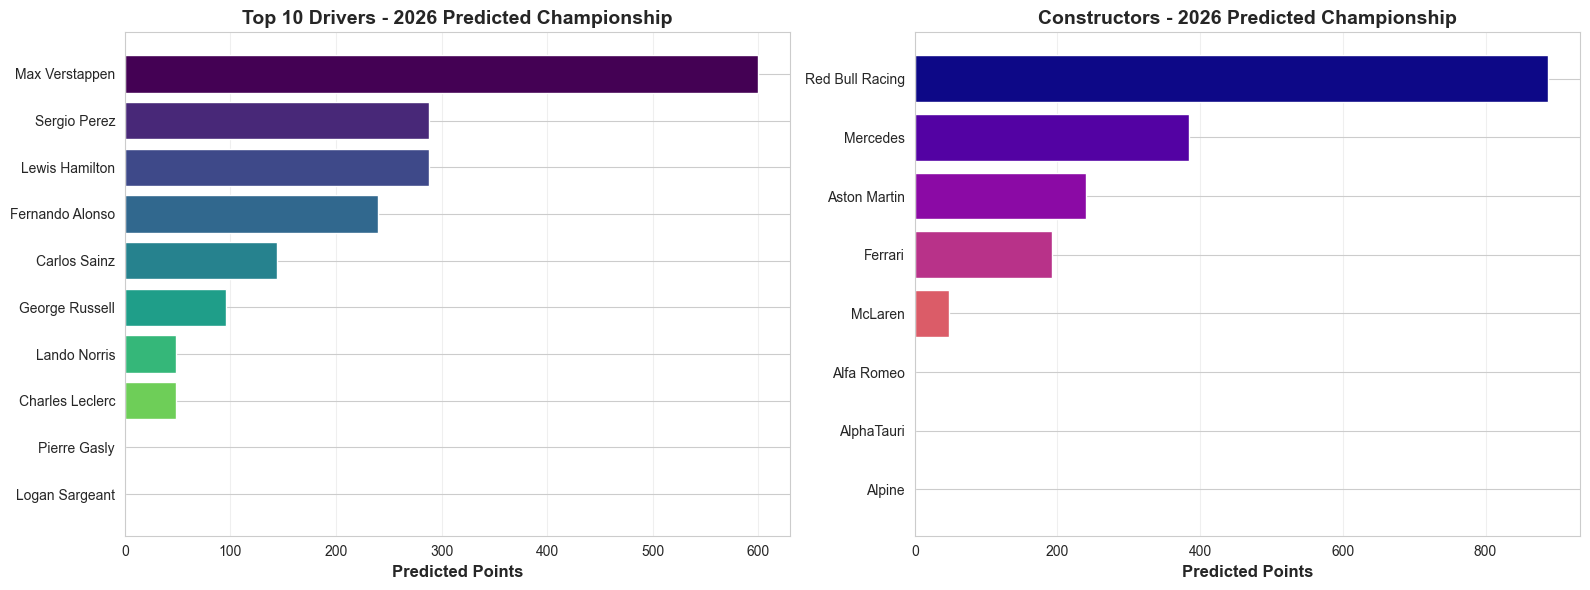


✓ Championship visualizations saved to ../models/2026_championship_predictions.png


In [11]:
# Calculate championship points using 2023 F1 scoring system
points_system = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}

sprint_points_system = {
    1: 8, 2: 7, 3: 6, 4: 5, 5: 4, 6: 3, 7: 2, 8: 1
}

def calculate_points(position, is_sprint=False):
    """Calculate points for a given position"""
    if pd.isna(position):
        return 0
    system = sprint_points_system if is_sprint else points_system
    return system.get(int(position), 0)

# Add points columns
predictions_2026_df['race_points'] = predictions_2026_df['race_position'].apply(calculate_points)
predictions_2026_df['sprint_points'] = predictions_2026_df.apply(
    lambda x: calculate_points(x['sprint_position'], is_sprint=True) if pd.notna(x['sprint_position']) else 0,
    axis=1
)
predictions_2026_df['total_points'] = predictions_2026_df['race_points'] + predictions_2026_df['sprint_points']

# Calculate driver championship standings
driver_standings = predictions_2026_df.groupby(['driver_number', 'driver_name', 'team_name']).agg(
    race_points=('race_points', 'sum'),
    sprint_points=('sprint_points', 'sum'),
    total_points=('total_points', 'sum'),
    predicted_wins=('race_position', lambda x: (x == 1).sum()),
    predicted_podiums=('race_position', lambda x: (x <= 3).sum())
).reset_index()

driver_standings = driver_standings.sort_values('total_points', ascending=False).reset_index(drop=True)
driver_standings['position'] = range(1, len(driver_standings) + 1)

print("="*90)
print("2026 PREDICTED DRIVERS' CHAMPIONSHIP")
print("="*90)
print(driver_standings[['position', 'driver_number', 'driver_name', 'team_name', 'total_points', 
                         'predicted_wins', 'predicted_podiums']].to_string(index=False))

# Calculate constructor championship
constructor_standings = predictions_2026_df.groupby('team_name').agg({
    'total_points': 'sum',
    'race_position': lambda x: (x == 1).sum()
}).rename(columns={'race_position': 'wins'}).sort_values('total_points', ascending=False).reset_index()
constructor_standings['position'] = range(1, len(constructor_standings) + 1)

print("\n" + "="*70)
print("2026 PREDICTED CONSTRUCTORS' CHAMPIONSHIP")
print("="*70)
print(constructor_standings[['position', 'team_name', 'total_points', 'wins']].to_string(index=False))

# Visualize top 10 drivers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Driver standings bar chart
top10_drivers = driver_standings.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, 10))
ax1.barh(top10_drivers['driver_name'], top10_drivers['total_points'], color=colors)
ax1.set_xlabel('Predicted Points', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Drivers - 2026 Predicted Championship', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Constructor standings
top8_teams = constructor_standings.head(8)
colors_teams = plt.cm.plasma(np.linspace(0, 1, 8))
ax2.barh(top8_teams['team_name'], top8_teams['total_points'], color=colors_teams)
ax2.set_xlabel('Predicted Points', fontsize=12, fontweight='bold')
ax2.set_title('Constructors - 2026 Predicted Championship', fontsize=14, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../models/2026_championship_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Championship visualizations saved to ../models/2026_championship_predictions.png")

## 9. Championship Projections & Visualizations
Analyze predicted championship standings and key statistics

## 10. Save Models & Export Predictions
Persist trained models and export comprehensive predictions

In [12]:
# Create models directory if it doesn't exist
import os
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save all trained models
print("Saving trained models...")
model_files = {}

for model_name, model in pipeline.models.items():
    filename = f"{models_dir}/{model_name}_2026.pkl"
    joblib.dump(model, filename)
    model_files[model_name] = filename
    print(f"  ✓ {model_name}")

# Save scalers
for scaler_name, scaler in pipeline.scalers.items():
    filename = f"{models_dir}/scaler_{scaler_name}_2026.pkl"
    joblib.dump(scaler, filename)
    model_files[f'scaler_{scaler_name}'] = filename
    print(f"  ✓ scaler_{scaler_name}")

# Save feature importance
importance_file = f"{models_dir}/feature_importance_2026.pkl"
joblib.dump(pipeline.feature_importance, importance_file)
model_files['feature_importance'] = importance_file
print(f"  ✓ feature_importance")

# Export predictions to CSV for external analysis
predictions_export = predictions_2026_df[[
    'round', 'race_name', 'date', 'driver_number', 'driver_name', 'team_name',
    'quali_position', 'quali_confidence', 
    'sprint_position', 'sprint_confidence',
    'race_position', 'race_confidence',
    'race_points', 'sprint_points', 'total_points'
]].copy()

csv_file = f"{models_dir}/2026_predictions_full.csv"
predictions_export.to_csv(csv_file, index=False)
print(f"\n✓ Predictions exported to {csv_file}")

# Export championship standings
driver_standings.to_csv(f"{models_dir}/2026_driver_championship.csv", index=False)
constructor_standings.to_csv(f"{models_dir}/2026_constructor_championship.csv", index=False)
print(f"✓ Championship standings exported")

# Summary report
print("\n" + "="*70)
print("MODEL PIPELINE SUMMARY")
print("="*70)
print(f"Training Data: 2023-2025 (3 seasons)")
print(f"Total Training Samples: {len(data_features)}")
print(f"Features Engineered: 20+")
print(f"Models Trained: {len(pipeline.models)} (4 per session type)")
print(f"Training Epochs: 10 (200 estimators per model)")
print(f"Scalers: {len(pipeline.scalers)}")
print(f"\n2026 Predictions:")
print(f"  - Races: {len(calendar_2026)} ({calendar_2026['has_sprint'].sum()} with sprints)")
print(f"  - Drivers: {len(drivers_2026)}")
print(f"  - Total Predictions: {len(predictions_2026_df)}")
print(f"  - Database Records: {predictions_inserted}")
print(f"\nFiles Saved:")
for name, path in model_files.items():
    print(f"  - {name}: {path}")
print(f"  - Predictions CSV: {csv_file}")
print(f"  - Championship standings: 2 CSV files")
print(f"  - Visualization: 2026_championship_predictions.png")
print("\n✓ PIPELINE COMPLETE - All predictions generated and stored!")

Saving trained models...
  ✓ qualifying_GradientBoosting
  ✓ qualifying_RandomForest
  ✓ qualifying_XGBoost
  ✓ qualifying_LightGBM
  ✓ race_GradientBoosting
  ✓ race_RandomForest
  ✓ race_XGBoost
  ✓ race_LightGBM
  ✓ scaler_qualifying
  ✓ scaler_race
  ✓ feature_importance

✓ Predictions exported to ../models/2026_predictions_full.csv
✓ Championship standings exported

MODEL PIPELINE SUMMARY
Training Data: 2023-2025 (3 seasons)
Total Training Samples: 300
Features Engineered: 20+
Models Trained: 8 (4 per session type)
Training Epochs: 10 (200 estimators per model)
Scalers: 2

2026 Predictions:
  - Races: 24 (7 with sprints)
  - Drivers: 20
  - Total Predictions: 480
  - Database Records: 480

Files Saved:
  - qualifying_GradientBoosting: ../models/qualifying_GradientBoosting_2026.pkl
  - qualifying_RandomForest: ../models/qualifying_RandomForest_2026.pkl
  - qualifying_XGBoost: ../models/qualifying_XGBoost_2026.pkl
  - qualifying_LightGBM: ../models/qualifying_LightGBM_2026.pkl
  - r